#### Basic

In [8]:
#import
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future
import numpy as np
from grid_world import standard_grid, negative_grid
from iterative_policy_evaluation import print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [2]:
#method
# NOTE: this is only policy evaluation, not optimization

def play_game(grid, policy):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this, because given our current deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
  while not grid.game_over():
    a = policy[s]
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s, r))
  # calculate the returns by working backwards from the terminal state
  G = 0
  states_and_returns = []
  first = True
  for s, r in reversed(states_and_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_and_returns.append((s, G))
    G = r + GAMMA*G
  states_and_returns.reverse() # we want it to be in order of state visited
  return states_and_returns

In [3]:
#main
if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
  }

  # initialize V(s) and returns
  V = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions:
      returns[s] = []
    else:
      # terminal state or state we can't otherwise get to
      V[s] = 0

  # repeat
  for t in range(100):

    # generate an episode using pi
    states_and_returns = play_game(grid, policy)
    seen_states = set()
    for s, G in states_and_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      if s not in seen_states:
        returns[s].append(G)
        V[s] = np.mean(returns[s])
        seen_states.add(s)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
values:
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00|-1.00| 0.00|
---------------------------
 0.66|-0.81|-0.90|-1.00|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


#### Monte Carlo es

In [4]:
#import
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt
from grid_world import standard_grid, negative_grid
from iterative_policy_evaluation import print_values, print_policy

GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [5]:
#method
# NOTE: this script implements the Monte Carlo Exploring-Starts method
#       for finding the optimal policy

def play_game(grid, policy):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this if we have a deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  # this is called the "exploring starts" method
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  a = np.random.choice(ALL_POSSIBLE_ACTIONS) # first action is uniformly random

  # be aware of the timing
  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  seen_states = set()
  seen_states.add(grid.current_state())
  num_steps = 0
  while True:
    r = grid.move(a)
    num_steps += 1
    s = grid.current_state()

    if s in seen_states:
      # hack so that we don't end up in an infinitely long episode
      # bumping into the wall repeatedly
      # if num_steps == 1 -> bumped into a wall and haven't moved anywhere
      #   reward = -10
      # else:
      #   reward = falls off by 1 / num_steps
      reward = -10. / num_steps
      states_actions_rewards.append((s, None, reward))
      break
    elif grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = policy[s]
      states_actions_rewards.append((s, a, r))
    seen_states.add(s)

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns

In [6]:
#method
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

rewards:
---------------------------
-0.90|-0.90|-0.90| 1.00|
---------------------------
-0.90| 0.00|-0.90|-1.00|
---------------------------
-0.90|-0.90|-0.90|-0.90|
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


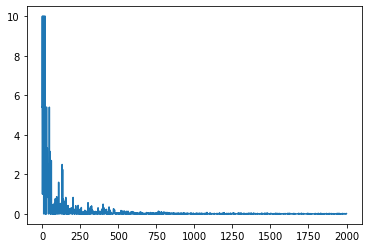

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  U  |
final values:
---------------------------
-1.77|-0.83| 1.00| 0.00|
---------------------------
-2.67| 0.00|-0.66| 0.00|
---------------------------
-3.15|-2.77|-1.69|-1.00|


In [7]:
#main
if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  # grid = standard_grid()
  # try the negative grid too, to see if agent will learn to go past the "bad spot"
  # in order to minimize number of steps
  grid = negative_grid(step_cost=-0.9)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # initialize a random policy
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

  # initialize Q(s,a) and returns
  Q = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions: # not a terminal state
      Q[s] = {}
      for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0 # needs to be initialized to something so we can argmax it
        returns[(s,a)] = []
    else:
      # terminal state or state we can't otherwise get to
      pass

  # repeat until convergence
  deltas = []
  for t in range(2000):
    if t % 100 == 0:
      print(t)

    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = play_game(grid, policy)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      sa = (s, a)
      if sa not in seen_state_action_pairs:
        old_q = Q[s][a]
        returns[sa].append(G)
        Q[s][a] = np.mean(returns[sa])
        biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
        seen_state_action_pairs.add(sa)
    deltas.append(biggest_change)

    # update policy
    for s in policy.keys():
      policy[s] = max_dict(Q[s])[0]

  plt.plot(deltas)
  plt.show()

  print("final policy:")
  print_policy(policy, grid)

  # find V
  V = {}
  for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]

  print("final values:")
  print_values(V, grid)

#### Monte Carlo no es

In [9]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt
from grid_world import standard_grid, negative_grid
from iterative_policy_evaluation import print_values, print_policy
from monte_carlo_es import max_dict

GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [10]:
# NOTE: find optimal policy and value function
#       using on-policy first-visit MC

def random_action(a, eps=0.1):
  # choose given a with probability 1 - eps + eps/4
  # choose some other a' != a with probability eps/4
  p = np.random.random()
  # if p < (1 - eps + eps/len(ALL_POSSIBLE_ACTIONS)):
  #   return a
  # else:
  #   tmp = list(ALL_POSSIBLE_ACTIONS)
  #   tmp.remove(a)
  #   return np.random.choice(tmp)
  #
  # this is equivalent to the above
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [11]:
#Method
def play_game(grid, policy):
  # returns a list of states and corresponding returns
  # in this version we will NOT use "exploring starts" method
  # instead we will explore using an epsilon-soft policy
  s = (2, 0)
  grid.set_state(s)
  a = random_action(policy[s])

  # be aware of the timing
  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  while True:
    r = grid.move(a)
    s = grid.current_state()
    if grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = random_action(policy[s]) # the next state is stochastic
      states_actions_rewards.append((s, a, r))

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
0
1000
2000
3000
4000


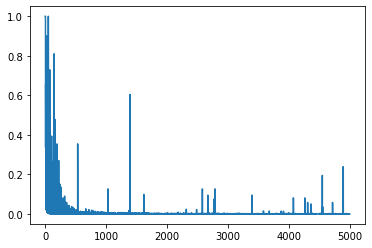

final values:
---------------------------
 0.58| 0.78| 1.00| 0.00|
---------------------------
 0.41| 0.00| 0.76| 0.00|
---------------------------
 0.25| 0.10|-0.23| 0.00|
final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  L  |  L  |  D  |


In [12]:
#main
if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  # grid = standard_grid()
  # try the negative grid too, to see if agent will learn to go past the "bad spot"
  # in order to minimize number of steps
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # initialize a random policy
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

  # initialize Q(s,a) and returns
  Q = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions: # not a terminal state
      Q[s] = {}
      for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0
        returns[(s,a)] = []
    else:
      # terminal state or state we can't otherwise get to
      pass

  # repeat until convergence
  deltas = []
  for t in range(5000):
    if t % 1000 == 0:
      print(t)

    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = play_game(grid, policy)

    # calculate Q(s,a)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      sa = (s, a)
      if sa not in seen_state_action_pairs:
        old_q = Q[s][a]
        returns[sa].append(G)
        Q[s][a] = np.mean(returns[sa])
        biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
        seen_state_action_pairs.add(sa)
    deltas.append(biggest_change)

    # calculate new policy pi(s) = argmax[a]{ Q(s,a) }
    for s in policy.keys():
      a, _ = max_dict(Q[s])
      policy[s] = a

  plt.plot(deltas)
  plt.show()

  # find the optimal state-value function
  # V(s) = max[a]{ Q(s,a) }
  V = {}
  for s in policy.keys():
    V[s] = max_dict(Q[s])[1]

  print("final values:")
  print_values(V, grid)
  print("final policy:")
  print_policy(policy, grid)

#### Monte Carlo Random

In [13]:
#import
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
from grid_world import standard_grid, negative_grid
from iterative_policy_evaluation import print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [14]:
#method
# NOTE: this is only policy evaluation, not optimization

def random_action(a):
  # choose given a with probability 0.5
  # choose some other a' != a with probability 0.5/3
  p = np.random.random()
  if p < 0.5:
    return a
  else:
    tmp = list(ALL_POSSIBLE_ACTIONS)
    tmp.remove(a)
    return np.random.choice(tmp)

In [15]:
#method
def play_game(grid, policy):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this, because given our current deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
  while not grid.game_over():
    a = policy[s]
    a = random_action(a)
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s, r))
  # calculate the returns by working backwards from the terminal state
  G = 0
  states_and_returns = []
  first = True
  for s, r in reversed(states_and_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_and_returns.append((s, G))
    G = r + GAMMA*G
  states_and_returns.reverse() # we want it to be in order of state visited
  return states_and_returns

In [16]:
#main
if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # found by policy_iteration_random on standard_grid
  # MC method won't get exactly this, but should be close
  # values:
  # ---------------------------
  #  0.43|  0.56|  0.72|  0.00|
  # ---------------------------
  #  0.33|  0.00|  0.21|  0.00|
  # ---------------------------
  #  0.25|  0.18|  0.11| -0.17|
  # policy:
  # ---------------------------
  #   R  |   R  |   R  |      |
  # ---------------------------
  #   U  |      |   U  |      |
  # ---------------------------
  #   U  |   L  |   U  |   L  |
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'U',
    (2, 1): 'L',
    (2, 2): 'U',
    (2, 3): 'L',
  }

  # initialize V(s) and returns
  V = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions:
      returns[s] = []
    else:
      # terminal state or state we can't otherwise get to
      V[s] = 0

  # repeat until convergence
  for t in range(5000):

    # generate an episode using pi
    states_and_returns = play_game(grid, policy)
    seen_states = set()
    for s, G in states_and_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      if s not in seen_states:
        returns[s].append(G)
        V[s] = np.mean(returns[s])
        seen_states.add(s)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
values:
---------------------------
 0.43| 0.56| 0.73| 0.00|
---------------------------
 0.33| 0.00| 0.23| 0.00|
---------------------------
 0.26| 0.20| 0.12|-0.16|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  L  |  U  |  L  |
